# Markers for cell mixture deconvolution comparison

In [1]:
library(CellMix)
library(limma)
library(linseed)

Loading required package: pkgmaker

Loading required package: registry

Warning message:
“package ‘registry’ was built under R version 3.5.2”
Loading required package: NMF

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 15/16

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: csSAM

Loading required package: Rcpp

Loading required package: stringr

Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Loading required package: GSEABase

Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:NMF’:

    nrun


The following object is masked from ‘package:pkgmaker’:

    new2


The following object is masked from ‘packag

In [2]:
options(repr.plot.height = 6, repr.plot.width = 8, repr.plot.res = 200)

## Initial dataset

In [3]:
em <- ExpressionMix("GSE19830", verbose=TRUE)
print(dim(em))
print(annotation(em))
head(pData(em)[c("Liver", "Brain", "Lung")])

Loading dataset 'GSE19830' ... OK
  Features    Samples Components 
     31099         42          3 
[1] "rat2302.db"


,Liver,Brain,Lung
,<dbl>,<dbl>,<dbl>
GSM495209,100,0,0
GSM495210,100,0,0
GSM495211,100,0,0
GSM495212,0,100,0
GSM495213,0,100,0
GSM495214,0,100,0


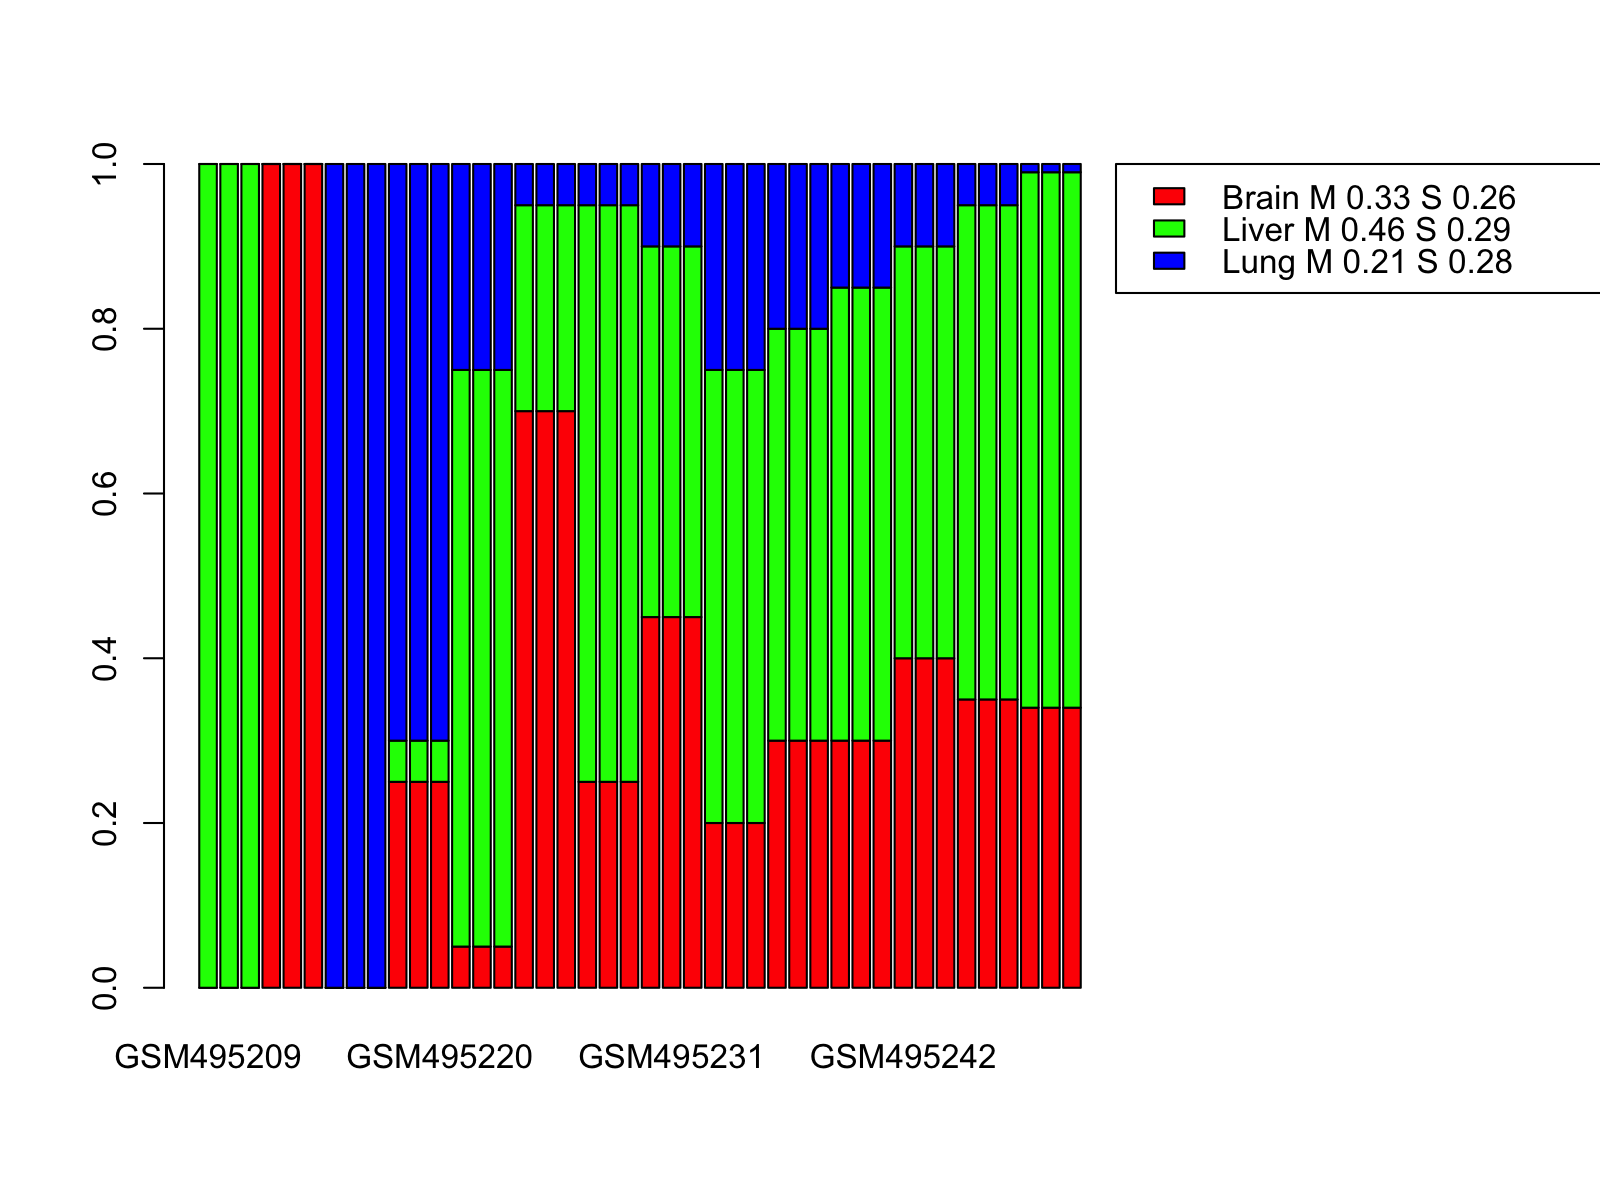

In [4]:
CellMix::propplot(em)

,Liver,Brain,Lung
,<dbl>,<dbl>,<dbl>
GSM495218,5,25,70
GSM495219,5,25,70
GSM495220,5,25,70
GSM495221,70,5,25
GSM495222,70,5,25
GSM495223,70,5,25


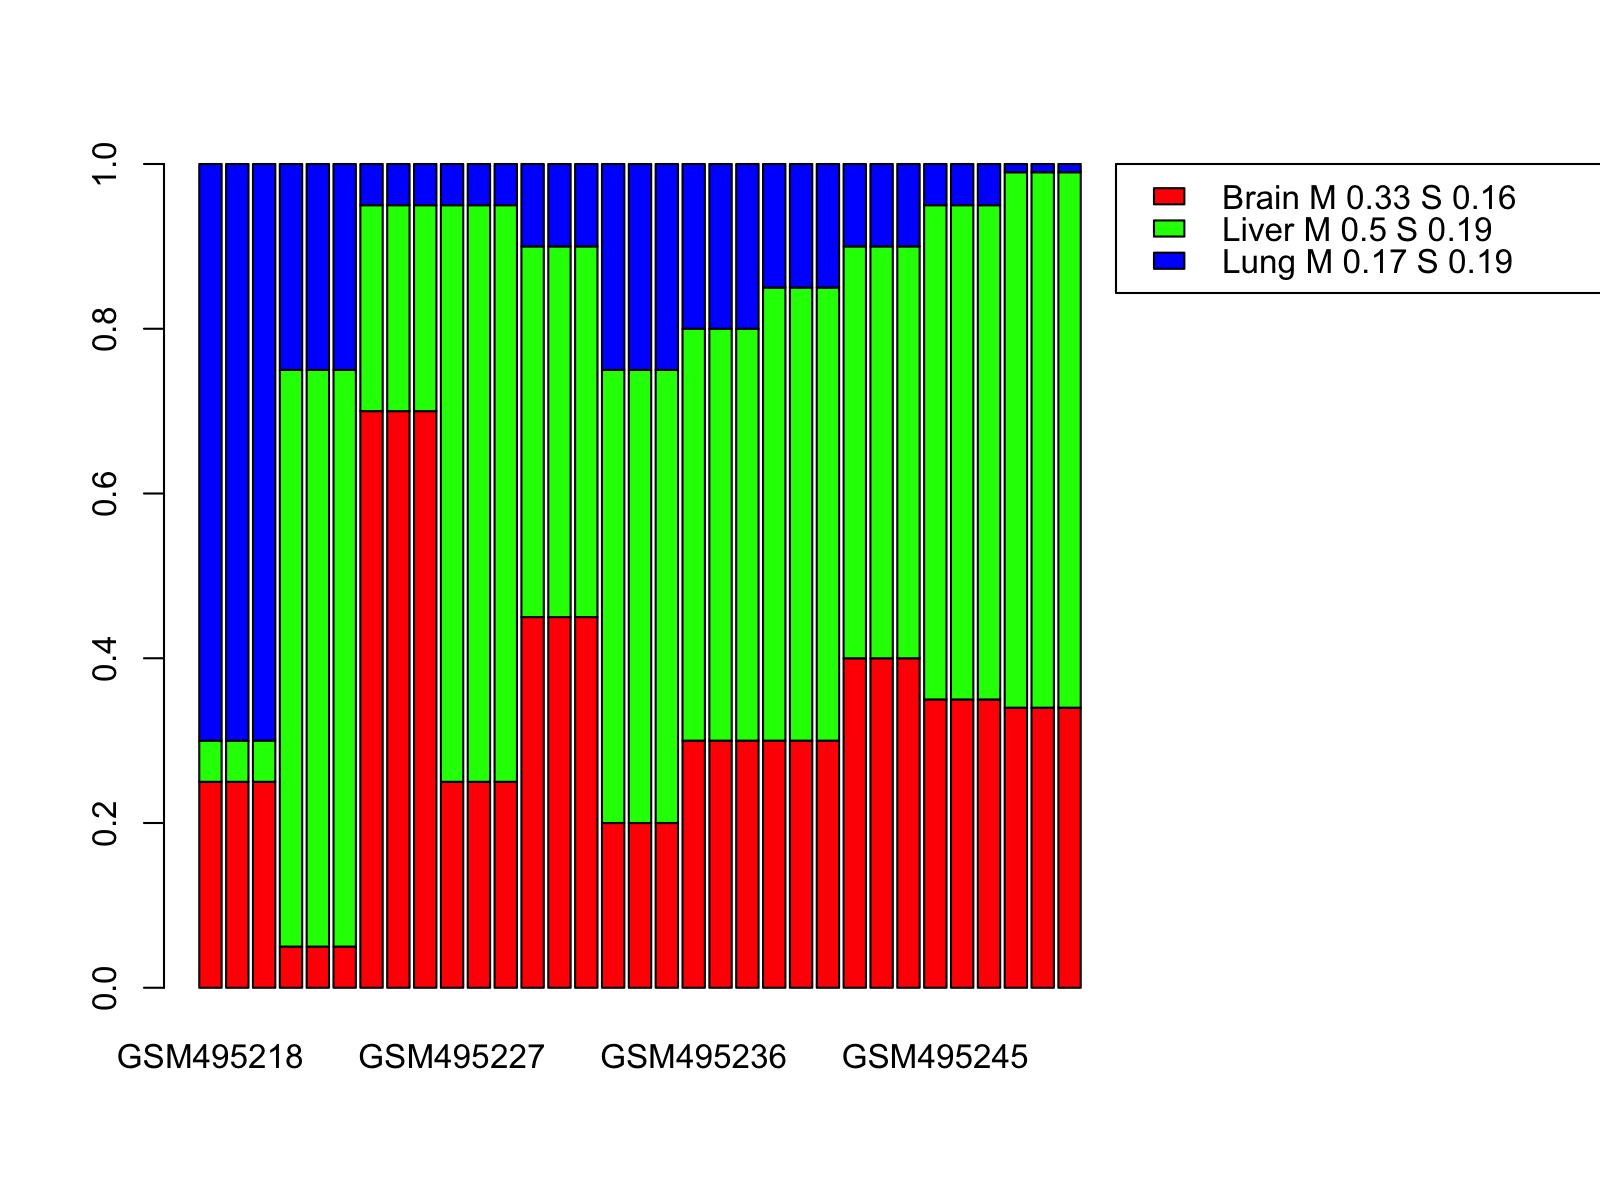

In [5]:
mix <- mixedSamples(em)
head(pData(mix)[c("Liver", "Brain", "Lung")])
propplot(mix)

## TIGER markers

In [6]:
ml.tiger <- MarkerList('TIGER')
ml.tiger <- ml.tiger[c('brain', 'liver', 'lung')]
summary(ml.tiger)

<object of class MarkerList>
Types: 3 ['brain', 'liver', 'lung'] 
Mode: numeric
Markers: 868 
IDtype: UNIGENE ['Hs.7124', 'Hs.12440', ..., 'Hs.228320'] 
Values: [7.26871, 7.26871, ..., 5.00013]
Source: org.Hs.eg.db 
Breakdown:
brain liver  lung 
  342   334   192

Convert markers to match annotation

In [7]:
ml.tiger <- convertIDs(ml.tiger, mix, verbose=TRUE)
summary(ml.tiger)

# Converting 868 markers from Unigene (org.Hs.eg.db) to Annotation (rat2302.db) ... OK [94/868 (1:1)]
# Processing 868 markers from Unigene (org.Hs.eg.db) to Annotation (rat2302.db) ... OK [94/868 (1:1)]


<object of class MarkerList>
Types: 3 ['brain', 'liver', 'lung'] 
Mode: numeric
Markers: 94 
IDtype: .Affymetrix ['1369882_at', '1398649_at', ..., '1370458_at'] 
Values: [7.26871, 7.26871, ..., 5.02528]
Source: rat2302.db 
Breakdown:
brain liver  lung 
   42    30    22

In [8]:
ml.filtered.tiger <- extractMarkers(ml.tiger, mix, method='SCOREM', alpha=10^-12)
summary(ml.filtered.tiger)

<object of class MarkerList>
Types: 3 ['brain', 'liver', 'lung'] 
Mode: numeric
Markers: 36 
IDtype: .Affymetrix ['1378796_at', '1387706_at', ..., '1379022_at'] 
Values: [0.951428251559581, 0.949254497124071, ..., 0.928822462190031]
Source: rat2302.db 
Breakdown:
brain liver  lung 
    8    23     5

## DE markers

### Data preprocessing

In [9]:
# Get only pure samples
ps <- pureSamples(em)

In [10]:
# Convert pData to 0 - 1 on brain/liver/lung, change colnames
pData(ps) <- (pData(ps)[, c("Brain", "Liver", "Lung")] / 100) %>% dplyr::mutate(tissue = pData(ps)[, "Type"]) %>% dplyr::mutate_all(as.factor)
colnames(pData(ps)) <- tolower(colnames(pData(ps)))
pData(ps)

,brain,liver,lung,tissue
,<fct>,<fct>,<fct>,<fct>
GSM495209,0,1,0,Liver
GSM495210,0,1,0,Liver
GSM495211,0,1,0,Liver
GSM495212,1,0,0,Brain
GSM495213,1,0,0,Brain
GSM495214,1,0,0,Brain
GSM495215,0,0,1,Lung
GSM495216,0,0,1,Lung
GSM495217,0,0,1,Lung


In [11]:
# Filter fData
fData(ps) <- fData(ps)[, c("ENTREZ_GENE_ID", "Gene Symbol")]

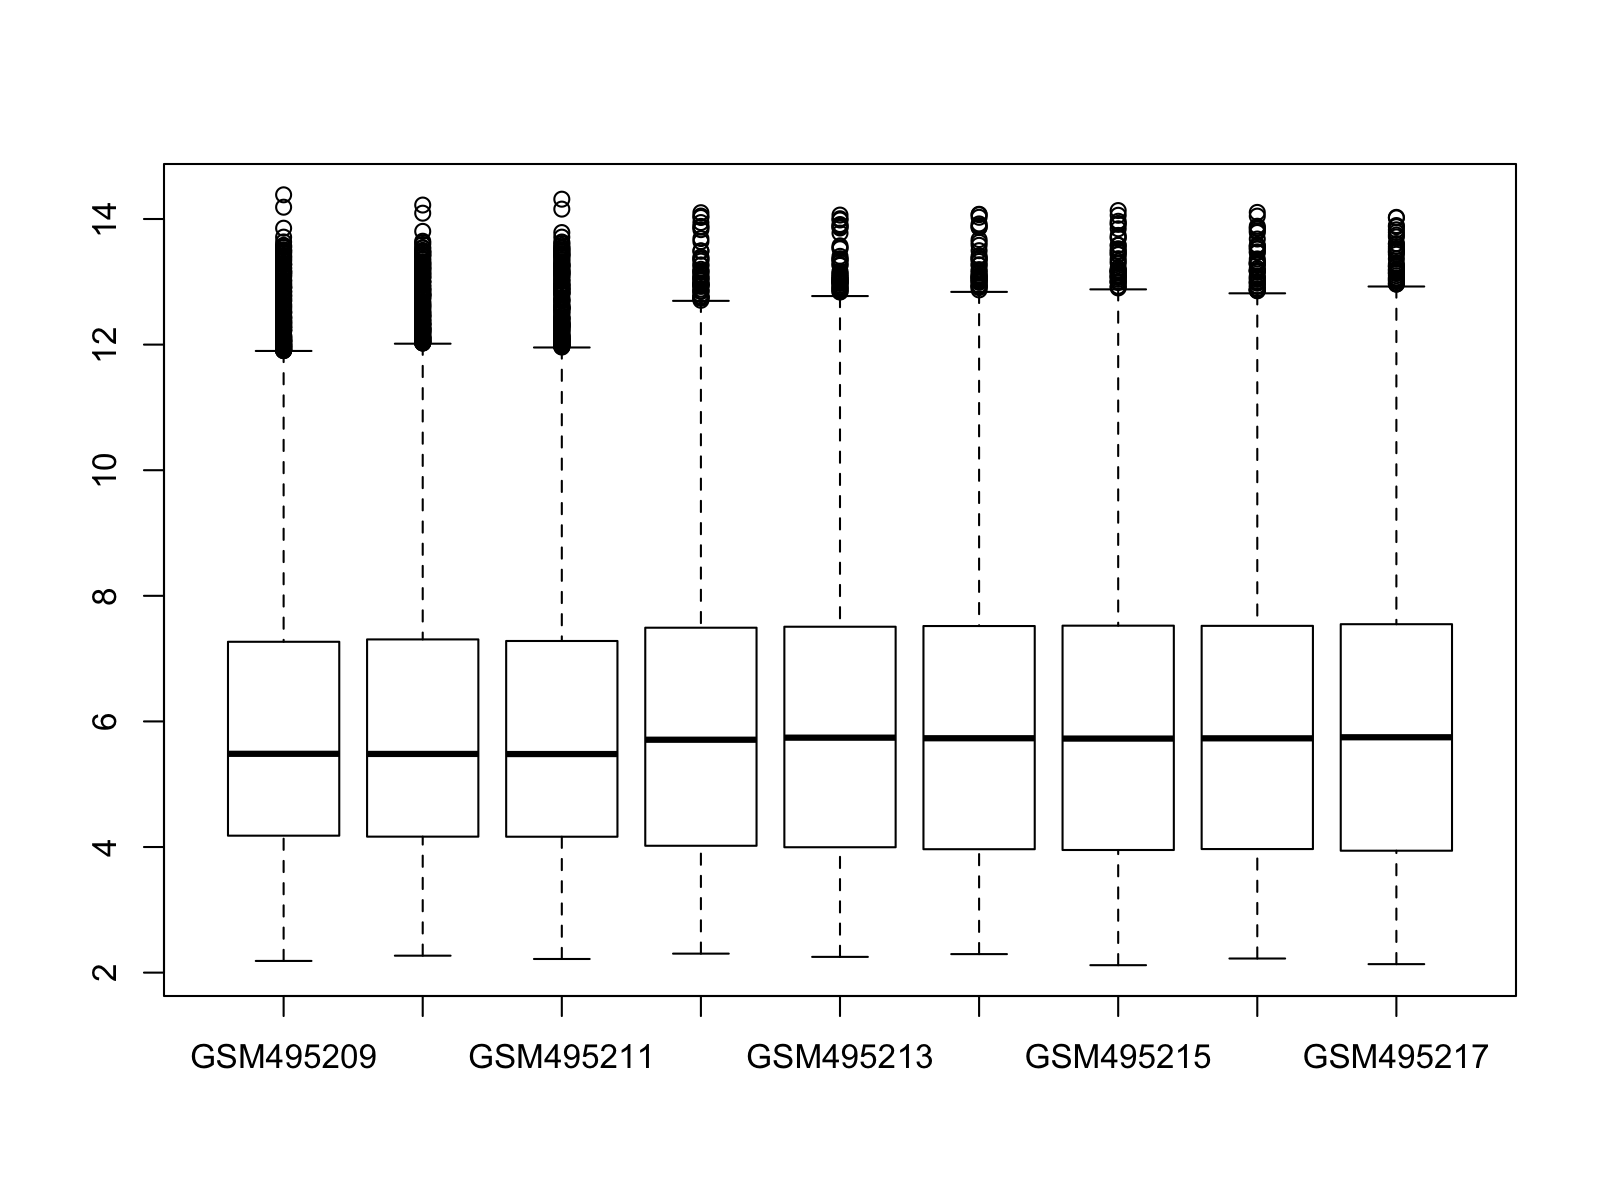

In [12]:
# Check scale
boxplot(exprs(ps))

In [13]:
# Drop duplicates, annotate with mean expression and sort by it
ps.flt <- ps[!duplicated(fData(ps)$`ENTREZ_GENE_ID`), ]
fData(ps.flt)$mean_expression <- apply(exprs(ps.flt), 1, mean)
ps.flt <- ps.flt[order(fData(ps.flt)$mean_expression, decreasing = TRUE), ]

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1554950)”


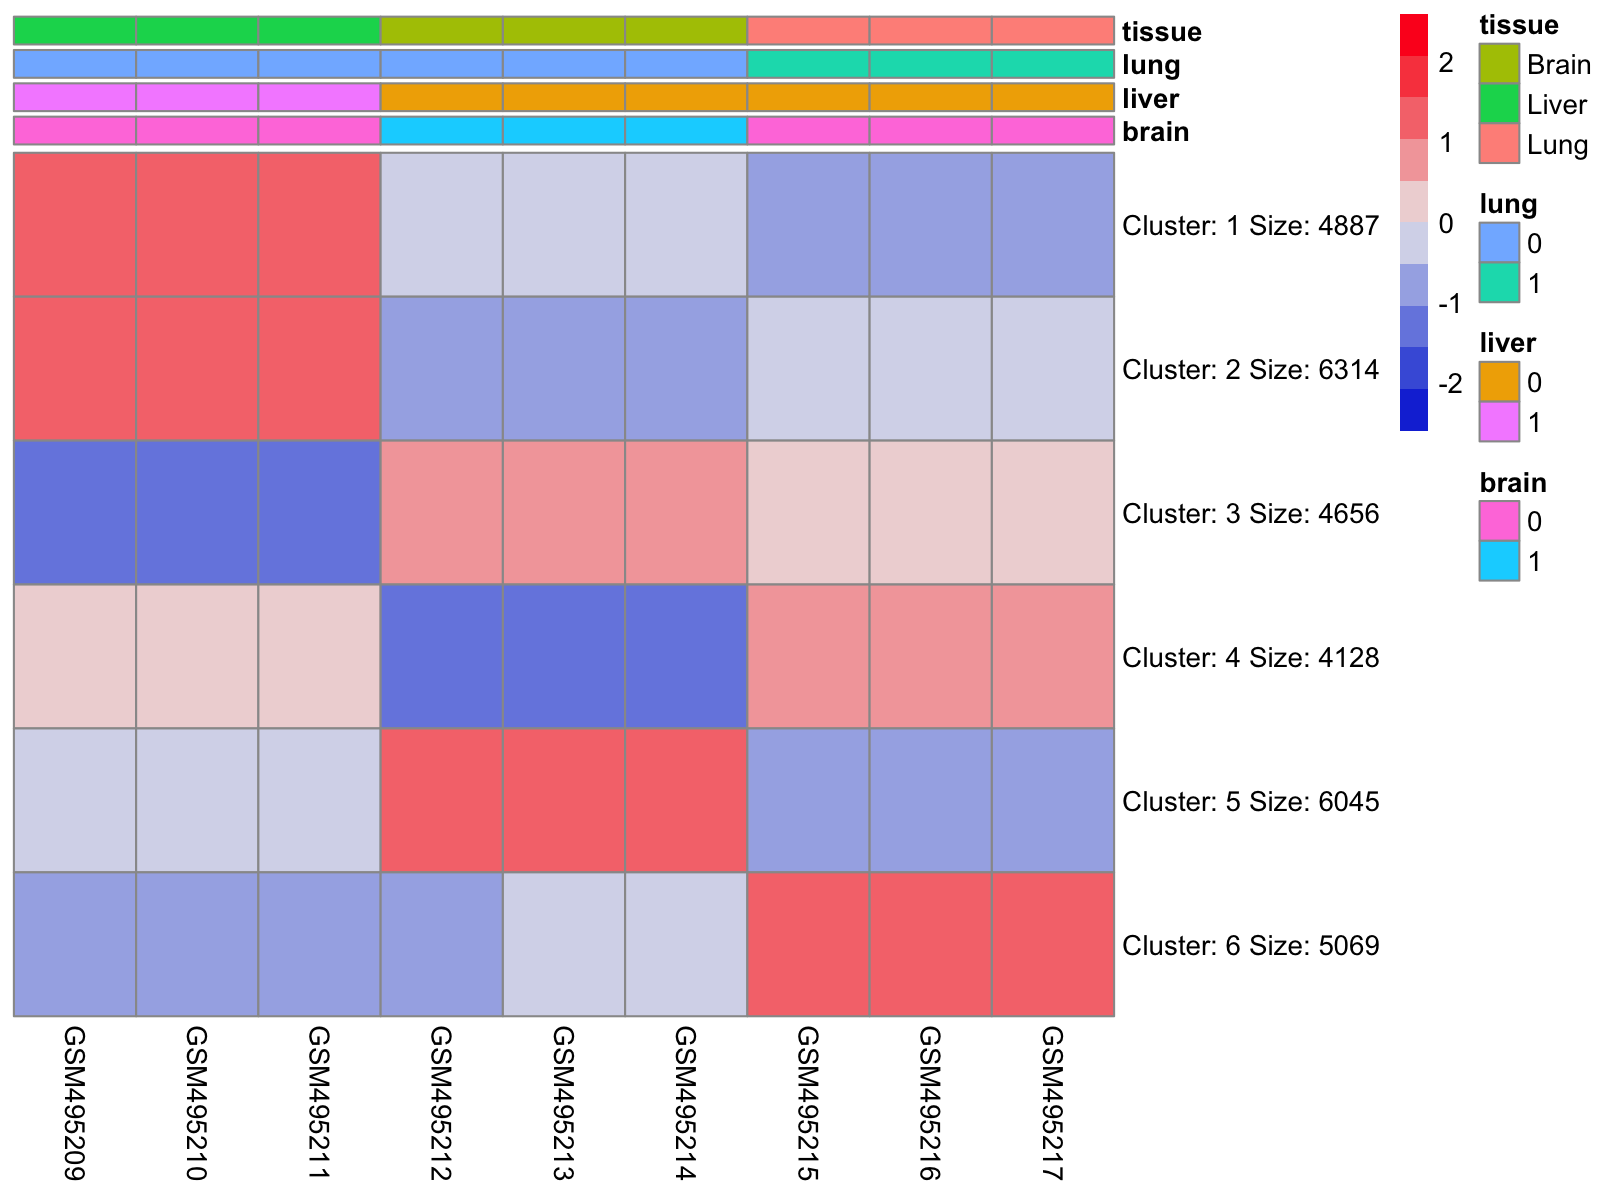

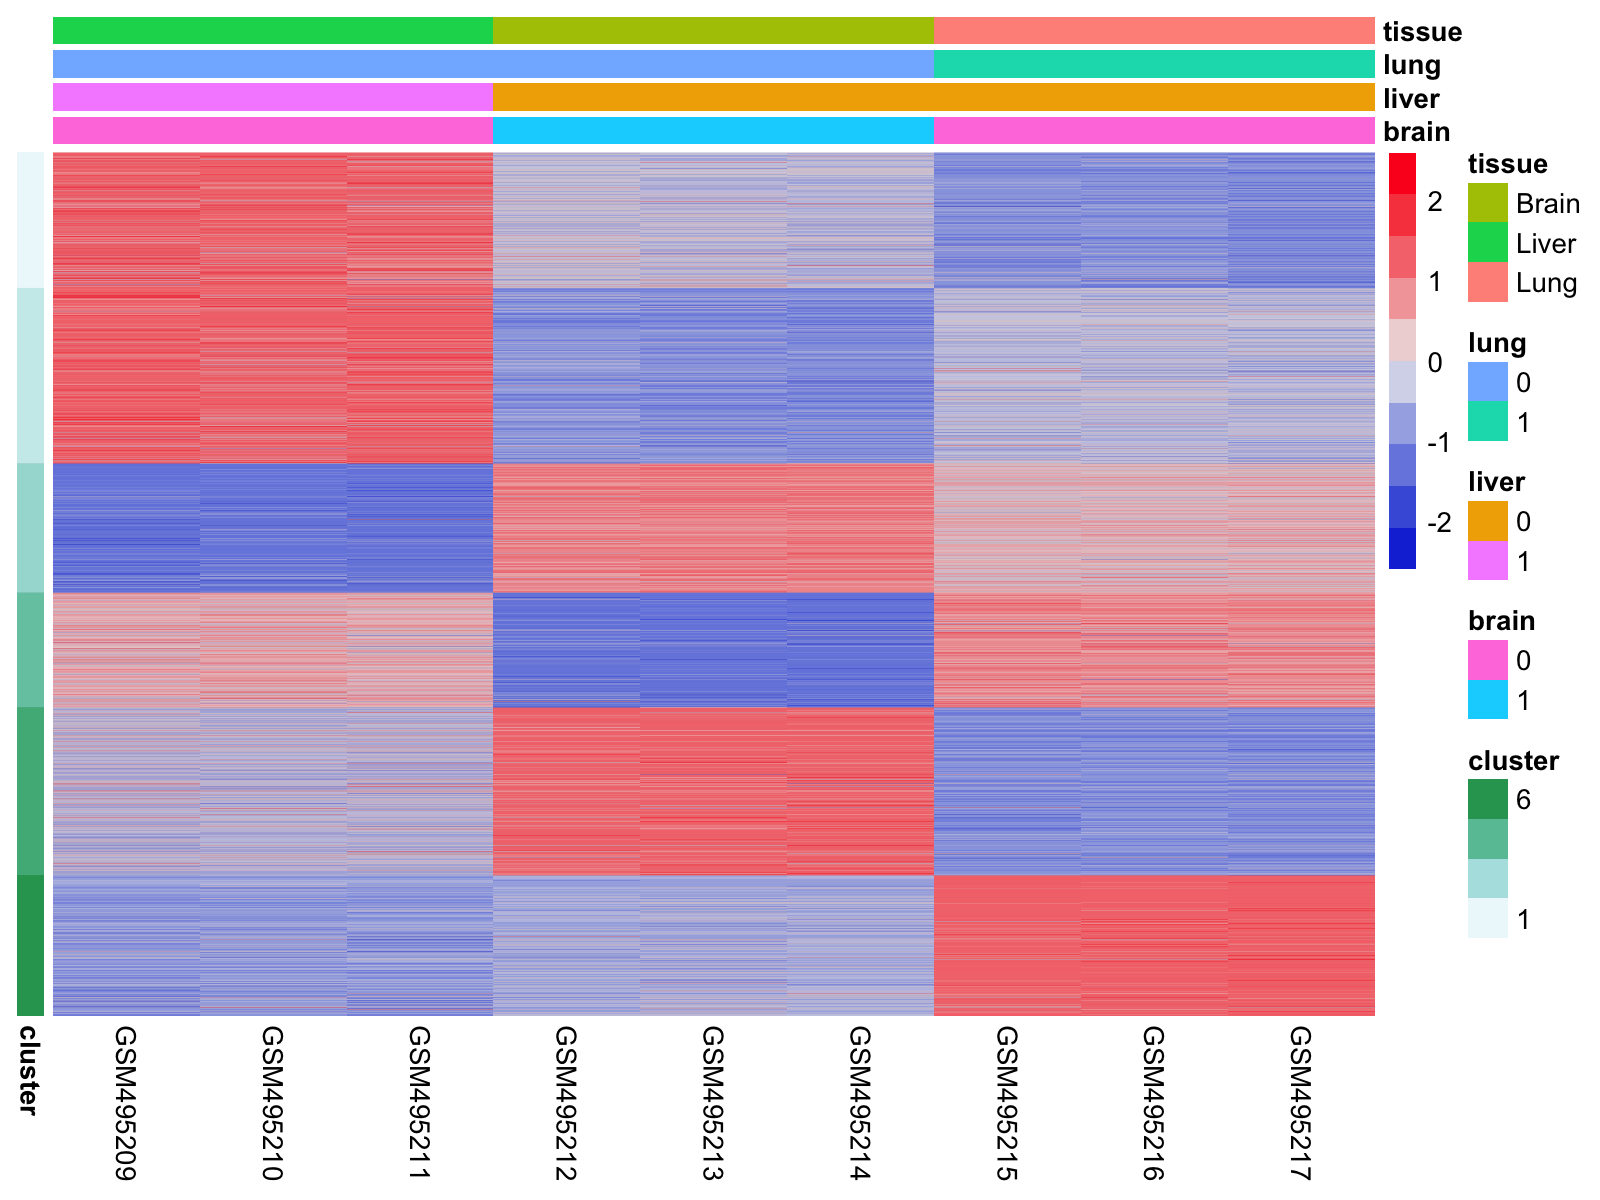

In [14]:
# Heatmap
blueWhiteRed <- colorRampPalette(c("#1839D8", "#EEEEEE", "#FD1920"))(10)
phmap <- pheatmap::pheatmap(exprs(ps), scale="row", cluster_rows = F, cluster_cols=F, kmeans_k = 6, color=blueWhiteRed, annotation_col = pData(ps))
phmap2 <- pheatmap::pheatmap(exprs(ps)[order(phmap$kmeans$cluster),], scale="row", cluster_rows = F, cluster_cols = F, color = blueWhiteRed, show_rownames = F, annotation_col = pData(ps), annotation_row = data.frame(cluster = phmap$kmeans$cluster))

### Differential expression

In [15]:
n.markers.each <- 30
adj.pval.threshold <- 0.01
stat <- "logFC"

getDeMarkers <- function(tissue, ps.data, n.markers.each = 30, adj.pval.threshold = 0.01, stat = "logFC") {
    design <- model.matrix(as.formula(str_interp("~1 + ${tissue}")), data=pData(ps.data))
    colnames(design) <- c("intercept", tissue)
    fit <- lmFit(ps.data, design)
    fit2 <- contrasts.fit(fit, makeContrasts(contrasts=tissue, levels = design))
    fit2 <- eBayes(fit2, trend = T)
    de <- topTable(fit2, adjust.method="BH", number=Inf, sort.by = stat)
    de <- de[de$adj.P.Val < adj.pval.threshold & de$logFC > 0,]
    de.markers <- rownames(head(de, n.markers.each))
    de.markers <- rowMeans(exprs(ps.data)[de.markers, pData(ps.data)[tissue] != 0])
    de.markers
}

de.markers.brain <- getDeMarkers("brain", ps.flt)
de.markers.liver <- getDeMarkers("liver", ps.flt)
de.markers.lung <- getDeMarkers("lung", ps.flt)

ml.de <- MarkerList(list(brain=de.markers.brain, liver=de.markers.liver, lung=de.markers.lung))
summary(ml.de)

<object of class MarkerList>
Types: 3 ['brain', 'liver', 'lung'] 
Mode: numeric
Markers: 90 
IDtype: .Affymetrix ['1368810_a_at', '1387073_at', ..., '1372615_at'] 
Values: [13.7123202133333, 13.3343667366667, ..., 11.61286155]
Breakdown:
brain liver  lung 
   30    30    30

In [16]:
ml.filtered.de <- extractMarkers(ml.de, mix, method='SCOREM', alpha=10^-12)
summary(ml.filtered.de)

<object of class MarkerList>
Types: 3 ['brain', 'liver', 'lung'] 
Mode: numeric
Markers: 90 
IDtype: .Affymetrix ['1368145_at', '1367845_at', ..., '1371076_at'] 
Values: [0.982390519475801, 0.982148000044698, ..., 0.953569005099126]
Source: rat2302.db 
Breakdown:
brain liver  lung 
   30    30    30

In [17]:
# To compare with phantasus
cat("Brain\n")
cat(names(de.markers.brain))
cat("\nLiver\n")
cat(names(de.markers.liver))
cat("\nLung\n")
cat(names(de.markers.lung))

Brain
1368810_a_at 1387073_at 1367851_at 1387112_at 1368344_at 1398625_at 1370201_at 1368044_at 1367845_at 1367992_at 1368145_at 1370058_at 1368656_at 1386903_at 1377125_at 1367930_at 1369977_at 1398258_at 1370517_at 1370815_at 1383783_at 1368170_at 1368034_at 1375905_at 1386998_at 1374187_at 1373333_at 1375877_at 1387288_at 1375861_at
Liver
1369502_a_at 1387994_at 1387314_at 1373686_at 1370511_at 1391417_at 1368188_at 1368569_at 1368720_at 1371083_at 1369509_a_at 1368707_at 1368442_at 1393139_at 1368397_at 1370359_at 1367917_at 1370547_at 1368686_at 1370580_a_at 1370992_a_at 1368048_at 1368731_at 1370151_at 1387034_at 1379240_at 1369111_at 1388229_a_at 1387949_at 1368335_at
Lung
1367566_at 1370255_at 1369107_at 1387460_at 1370980_at 1383145_at 1387960_at 1388224_at 1370401_at 1371700_at 1373911_at 1368168_at 1389734_x_at 1381318_at 1382833_at 1368521_at 1387315_at 1367661_at 1376828_at 1368423_at 1373617_at 1389732_at 1371970_at 1374070_at 1388433_at 1387159_at 1371076_at 1370257_at 1

## Markers profiles

Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”


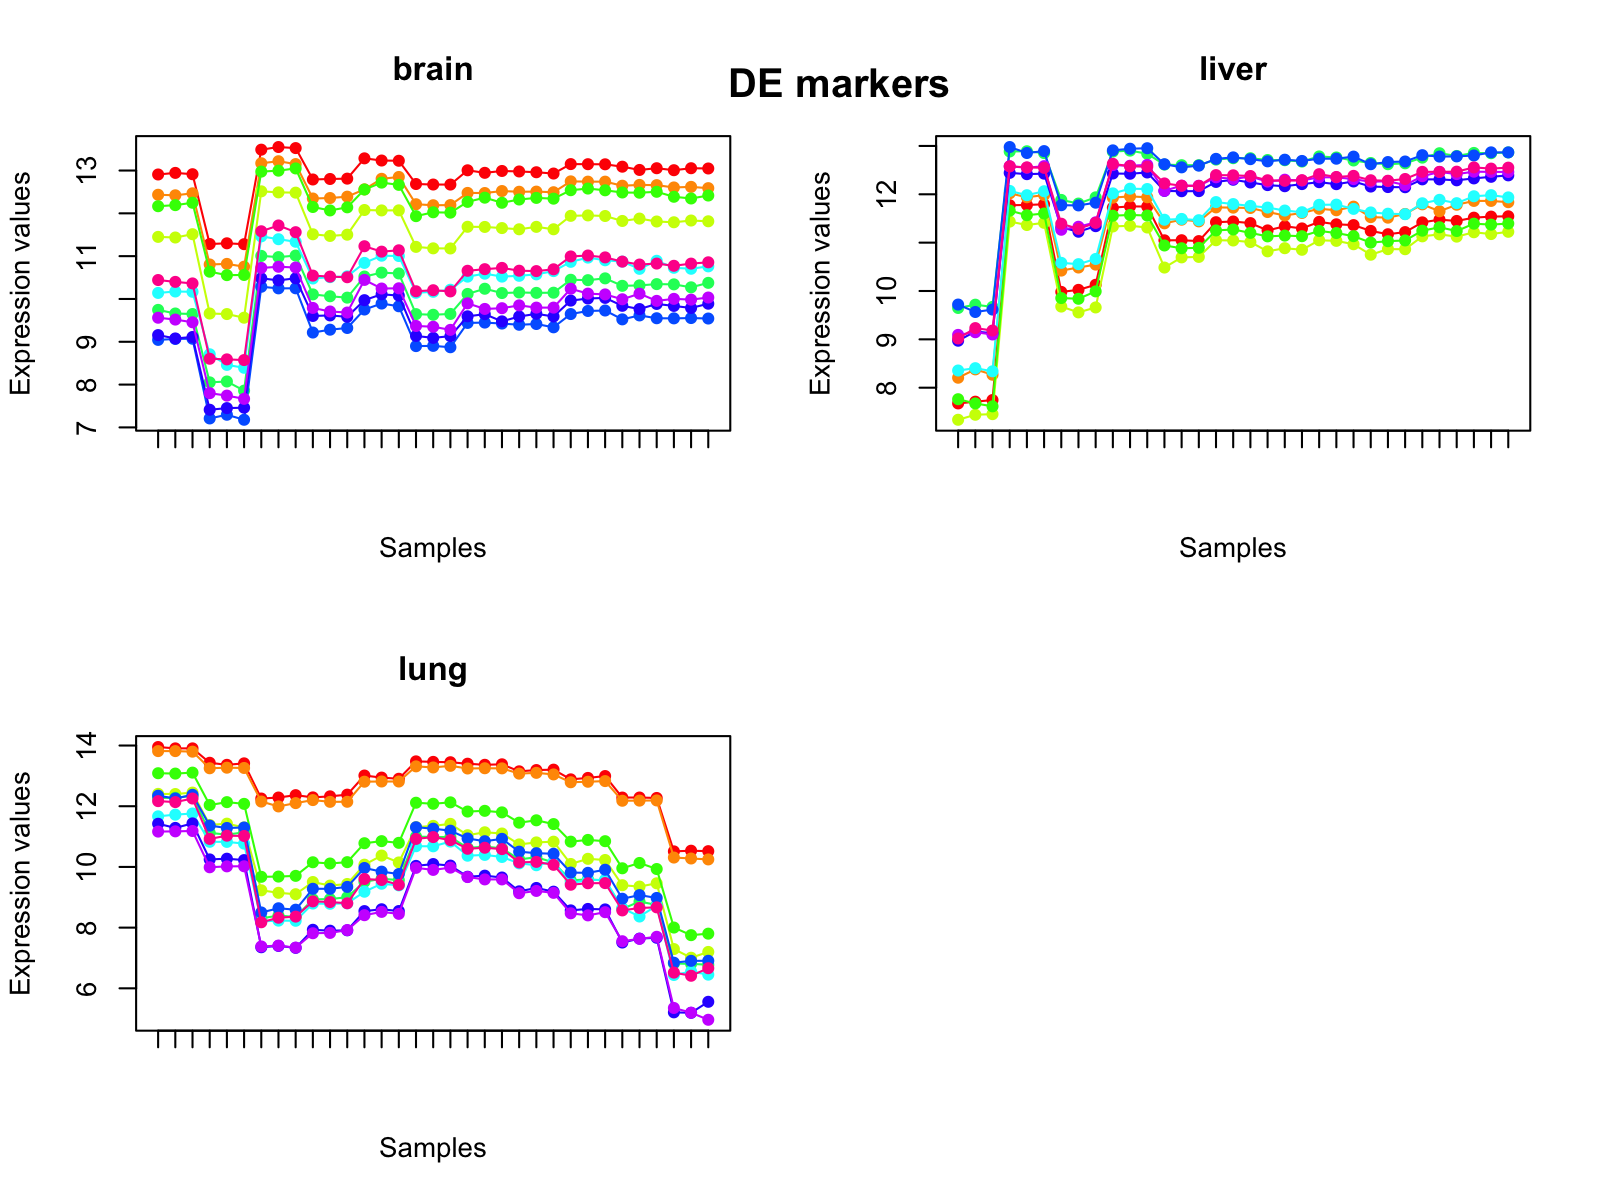

In [18]:
profplot(ml.de[,1:10], mix)
title("DE markers")

Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”


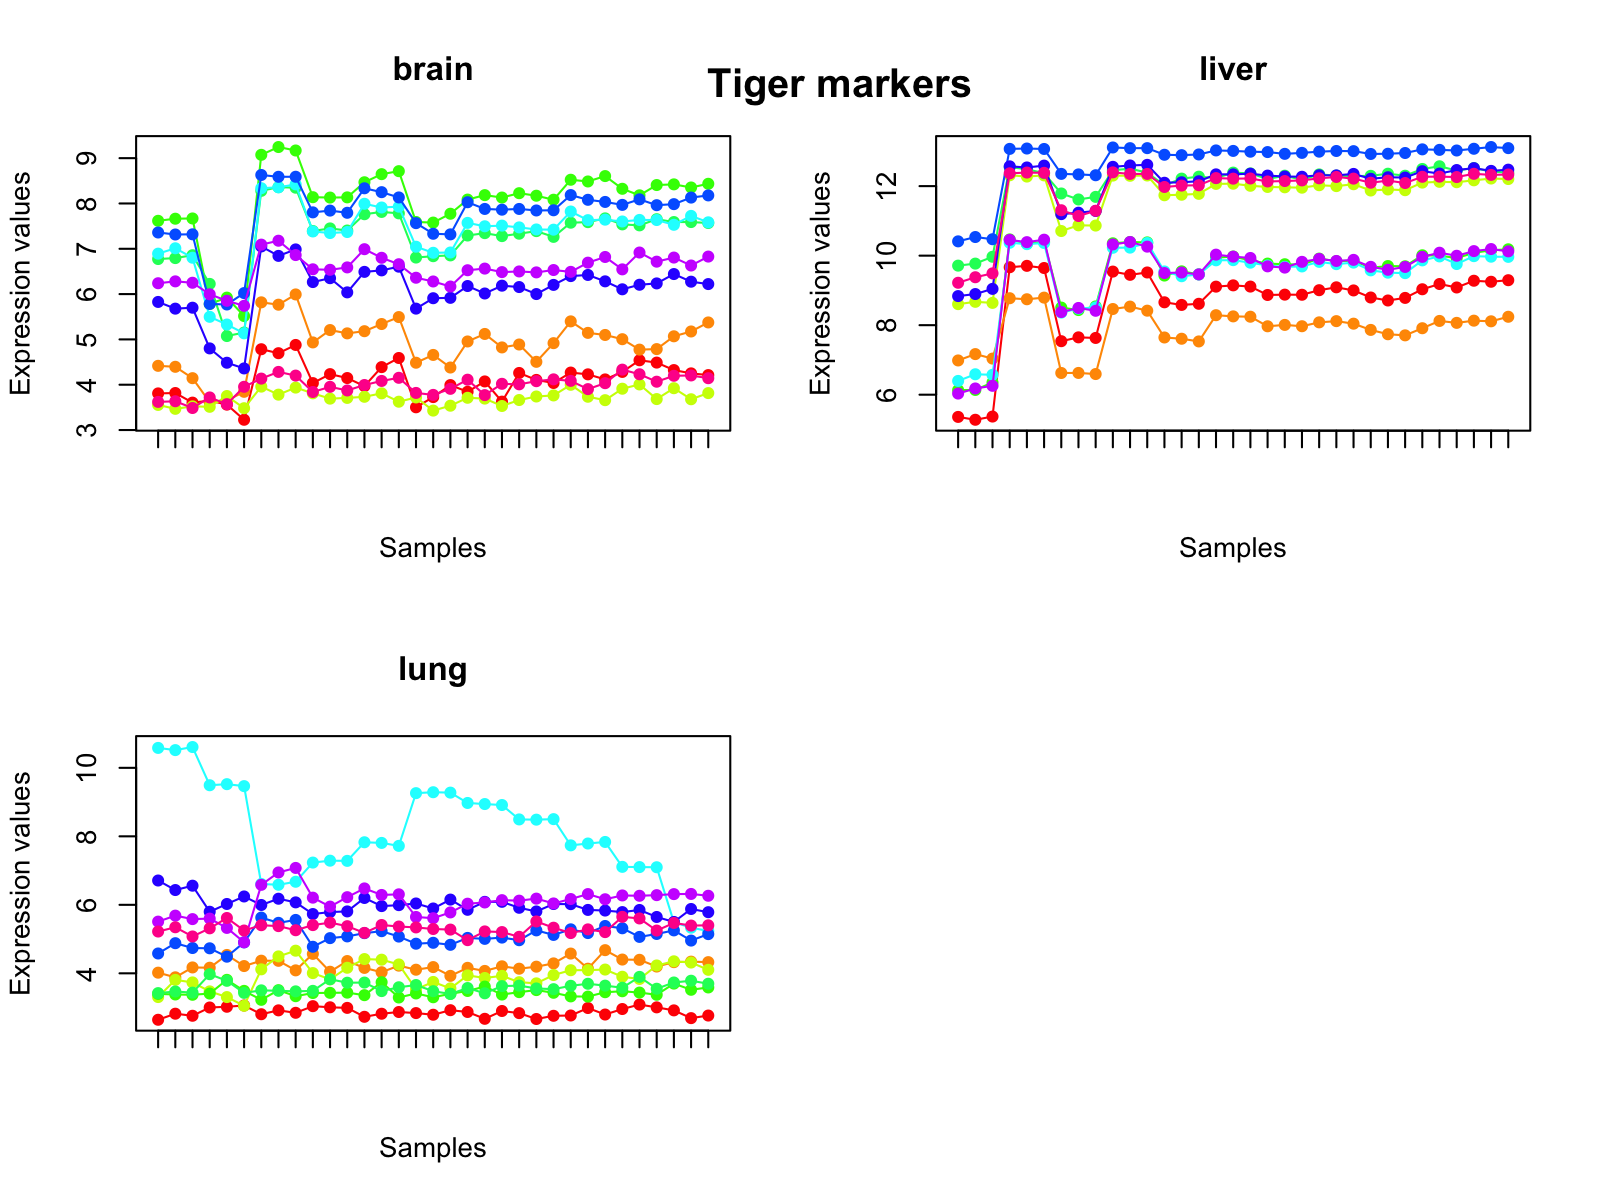

In [19]:
profplot(ml.tiger[,1:10], mix)
title("Tiger markers")

Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”


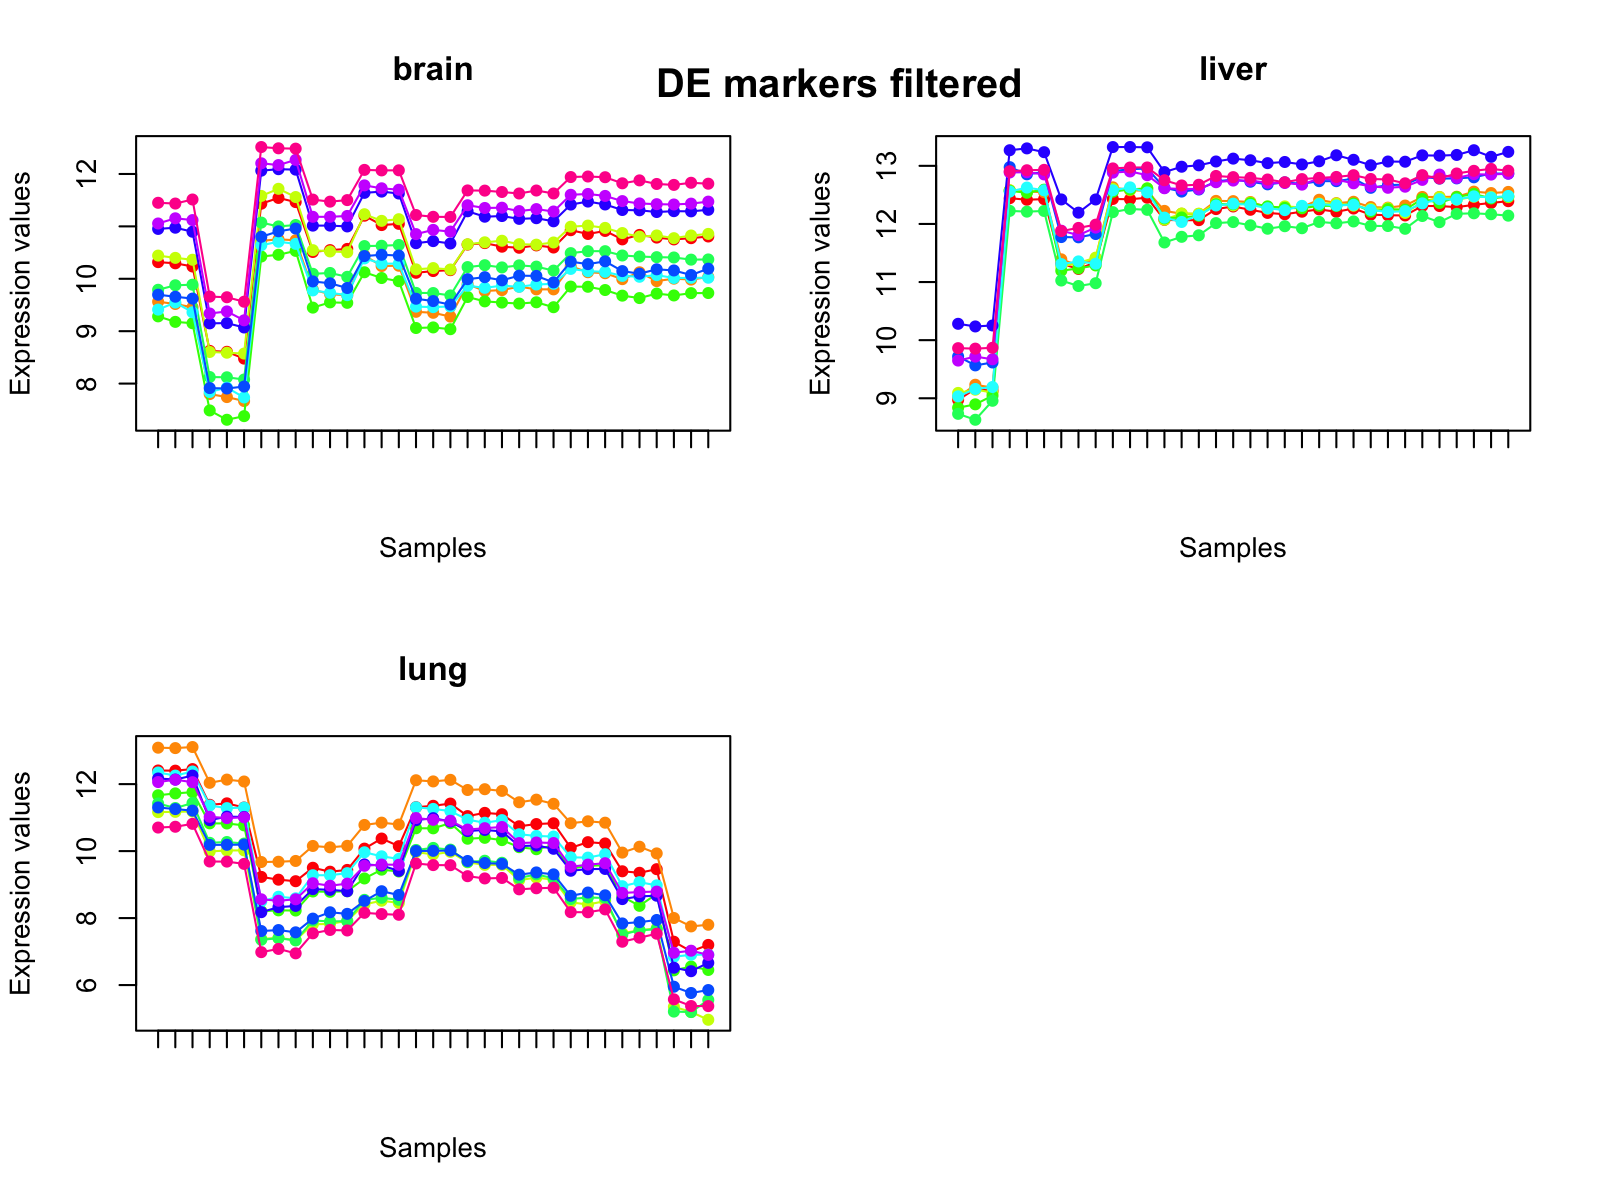

In [20]:
profplot(ml.filtered.de[,1:10], mix)
title("DE markers filtered")

Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”
Warning message in rep(labels, length.out = ncol(x)):
“'x' is NULL so the result will be NULL”


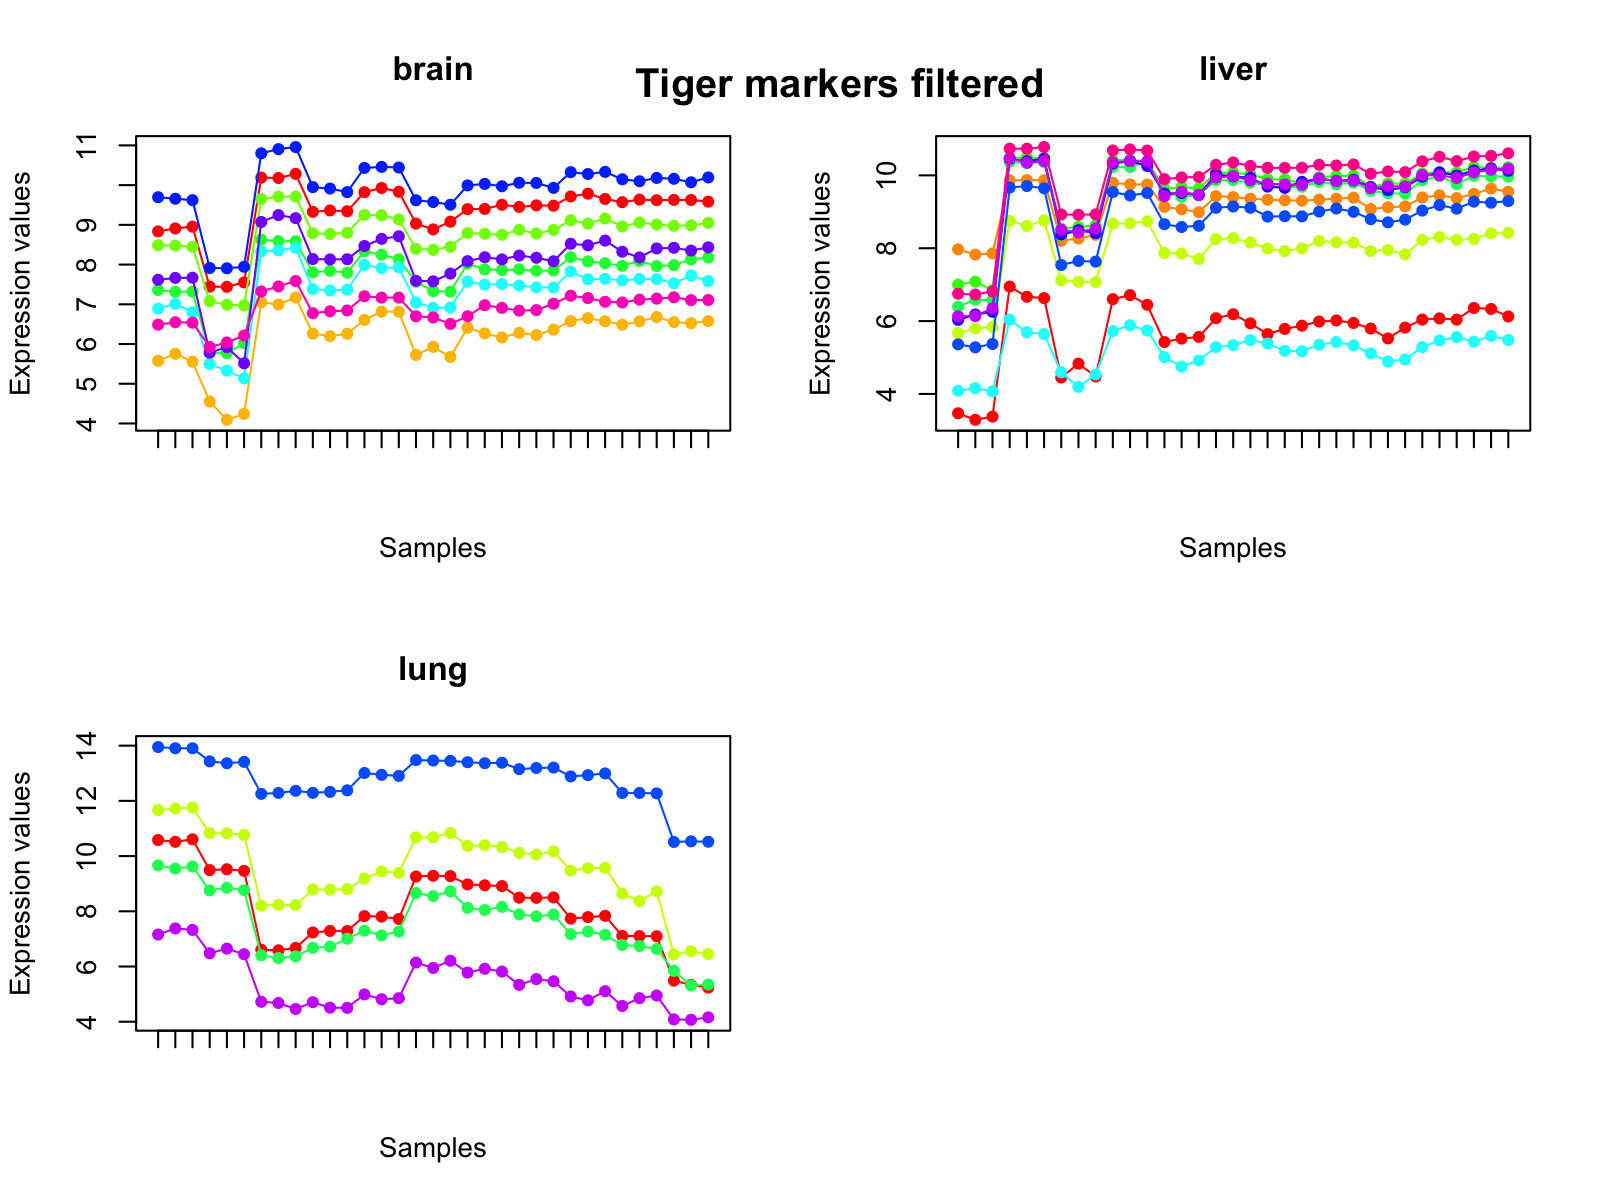

In [21]:
profplot(ml.filtered.tiger[,1:10], mix)
title("Tiger markers filtered")

## Partial deconvolution models comparison

In [52]:
mix.lin <- eset(mix)
exprs(mix.lin) <- 2 ^ exprs(mix.lin)
mix <- ExpressionMix(mix.lin, composition=mix)

In [56]:
model.dsa.filtered.tiger <- ged(mix[ml.filtered.tiger,], x = ml.filtered.tiger, 'DSA', verbose=TRUE)
model.lee.filtered.tiger <- ged(mix, x = 3, method = 'ssFrobenius', data = ml.filtered.tiger, verbose = T)
model.dsa.tiger <- ged(mix[ml.tiger,], x = ml.tiger, 'DSA', verbose=TRUE)
model.lee.tiger <- ged(mix, x = 3, method = 'ssFrobenius', data = ml.tiger, verbose = T)

  Using ged algorithm: “DSA”
   Estimating basis and mixture coefficients matrices from marker features [DSA]
   Using 36/36 markers to estimate cell proportions: 
 brain liver  lung 
     8    23     5 
   Checking data scale ...    OK [linear]
   Computing proportions using DSA method ...    OK
   Estimating basis matrix from mixture coefficients [qprog]
   Not using any marker constraints
  Timing:
   user  system elapsed 
  0.471   0.018   0.489 
  GED final wrap up ...   OK
  Using ged algorithm: “ssFrobenius”
  Timing:
   user  system elapsed 
 32.477   1.483  34.037 
  GED final wrap up ...   OK
  Using ged algorithm: “DSA”
   Estimating basis and mixture coefficients matrices from marker features [DSA]
   Using 94/94 markers to estimate cell proportions: 
 brain liver  lung 
    42    30    22 
   Checking data scale ...    OK [linear]
   Computing proportions using DSA method ...    OK
   Estimating basis matrix from mixture coefficients [qprog]
   Not using any marker constra

In [57]:
model.dsa.filtered.de <- ged(mix[ml.filtered.de,], x = ml.filtered.de, 'DSA', verbose=TRUE)
model.lee.filtered.de <- ged(mix, x = 3, method = 'ssFrobenius', data = ml.filtered.de, verbose = T)
model.dsa.de <- ged(mix[ml.de,], x = ml.de, 'DSA', verbose=TRUE)
model.lee.de <- ged(mix, x = 3, method = 'ssFrobenius', data = ml.de, verbose = T)

  Using ged algorithm: “DSA”
   Estimating basis and mixture coefficients matrices from marker features [DSA]
   Using 90/90 markers to estimate cell proportions: 
 brain liver  lung 
    30    30    30 
   Checking data scale ...    OK [linear]
   Computing proportions using DSA method ...    OK
   Estimating basis matrix from mixture coefficients [qprog]
   Not using any marker constraints
  Timing:
   user  system elapsed 
  0.410   0.001   0.411 
  GED final wrap up ...   OK
  Using ged algorithm: “ssFrobenius”
  Timing:
   user  system elapsed 
 34.335   1.609  36.106 
  GED final wrap up ...   OK
  # Converting 90 markers from Annotation to Annotation (rat2302.db) ...   OK [90/90 (1:1)]
  # Processing 90 markers from Annotation to Annotation (rat2302.db) ...   OK [90/90 (1:1)]
  Using ged algorithm: “DSA”
   Estimating basis and mixture coefficients matrices from marker features [DSA]
   Using 90/90 markers to estimate cell proportions: 
 brain liver  lung 
    30    30    30 
  

In [58]:
# True answer
correct_order <- c("liver", "brain", "lung")
proportions.true <- t(pData(mix)[c("Liver", "Brain", "Lung")]/100)
rownames(proportions.true) <- correct_order

In [59]:
# Create new variables from different sources
proportions.dsa.filtered.tiger <- .coef(model.dsa.filtered.tiger)
proportions.lee.filtered.tiger <- .coef(model.lee.filtered.tiger)
proportions.dsa.filtered.de <- .coef(model.dsa.filtered.de)
proportions.lee.filtered.de <- .coef(model.lee.filtered.de)
proportions.dsa.tiger <- .coef(model.dsa.tiger)
proportions.lee.tiger <- .coef(model.lee.tiger)
proportions.dsa.de <- .coef(model.dsa.de)
proportions.lee.de <- .coef(model.lee.de)

# Reorder rows where needed
proportions.dsa.filtered.tiger <- proportions.dsa.filtered.tiger[correct_order,]
proportions.lee.filtered.tiger <- proportions.lee.filtered.tiger[correct_order,]
proportions.dsa.filtered.de <- proportions.dsa.filtered.de[correct_order,]
proportions.lee.filtered.de <- proportions.lee.filtered.de[correct_order,]
proportions.dsa.tiger <- proportions.dsa.tiger[correct_order,]
proportions.lee.tiger <- proportions.lee.tiger[correct_order,]
proportions.dsa.de <- proportions.dsa.de[correct_order,]
proportions.lee.de <- proportions.lee.de[correct_order,]

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


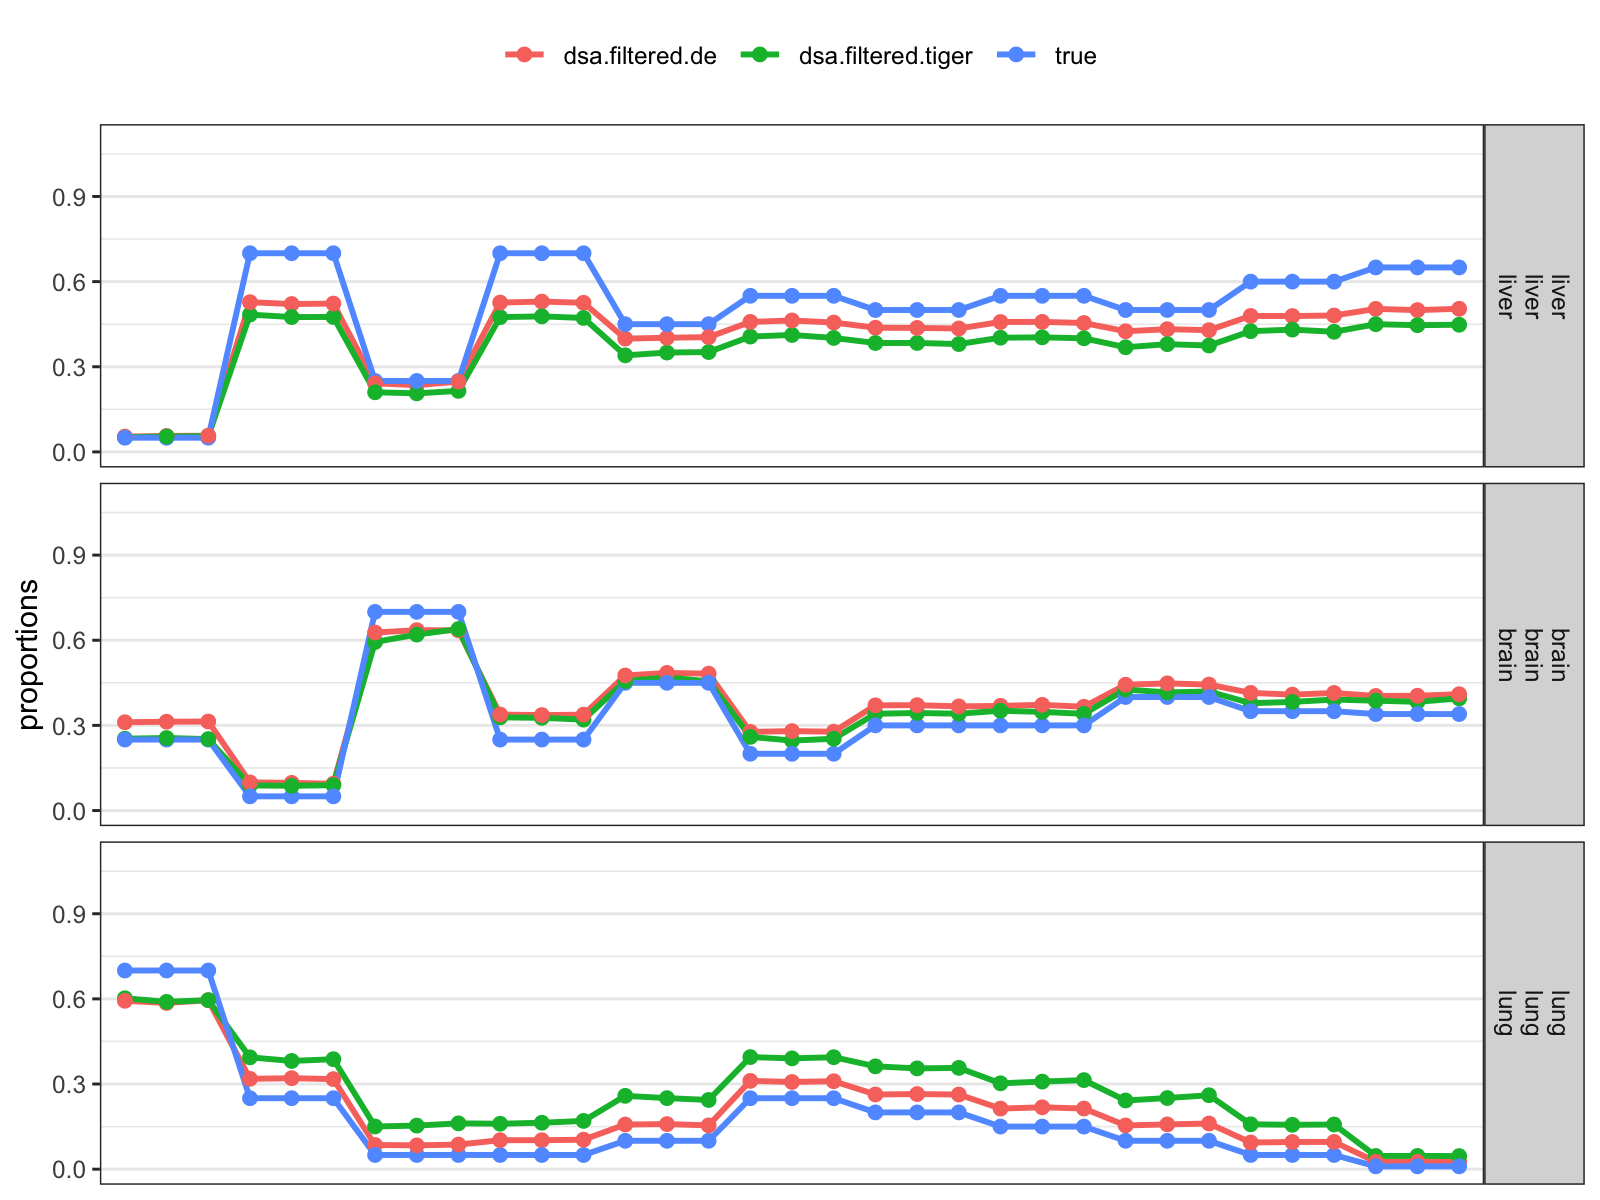

In [60]:
proportions.dsa.filtered <- list(dsa.filtered.tiger = proportions.dsa.filtered.tiger, dsa.filtered.de = proportions.dsa.filtered.de, true = proportions.true)
do.call(plotProportions, c(proportions.dsa.filtered, pnames = list(names(proportions.dsa.filtered))))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


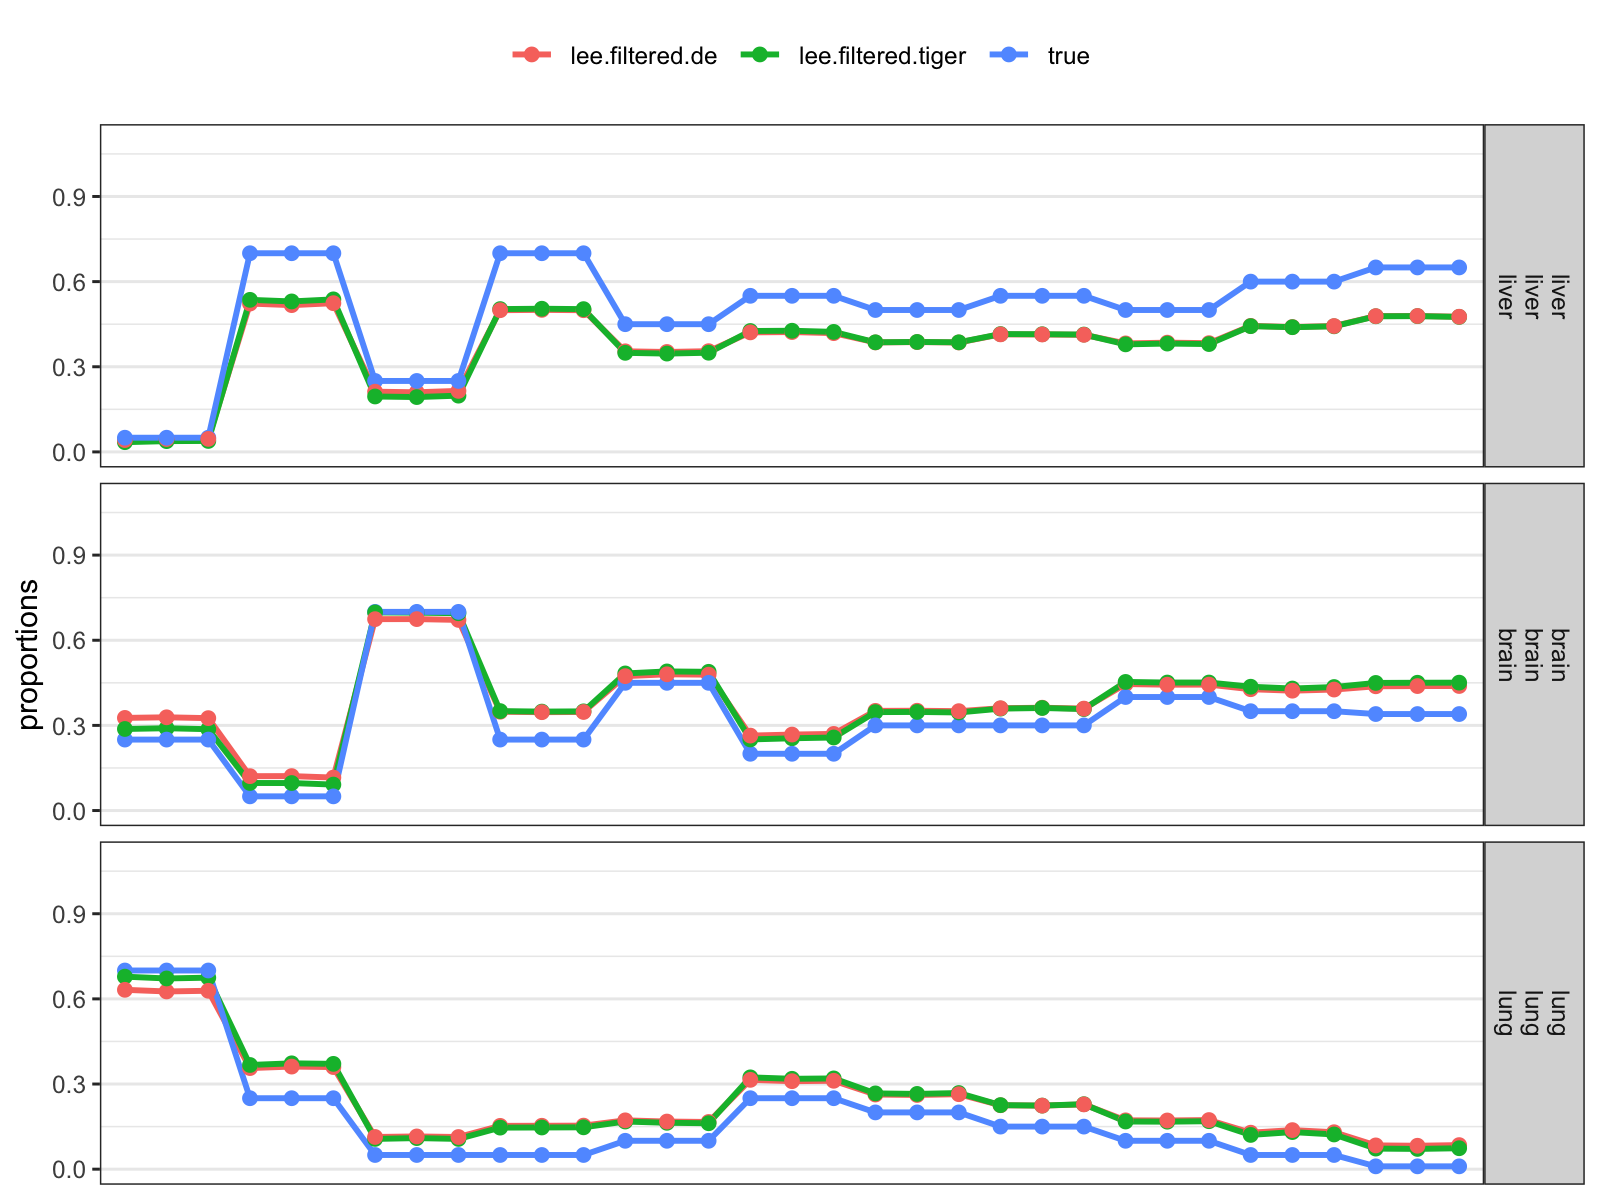

In [61]:
proportions.lee.filtered <- list(lee.filtered.tiger = proportions.lee.filtered.tiger, lee.filtered.de = proportions.lee.filtered.de, true = proportions.true)
do.call(plotProportions, c(proportions.lee.filtered, pnames = list(names(proportions.lee.filtered))))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


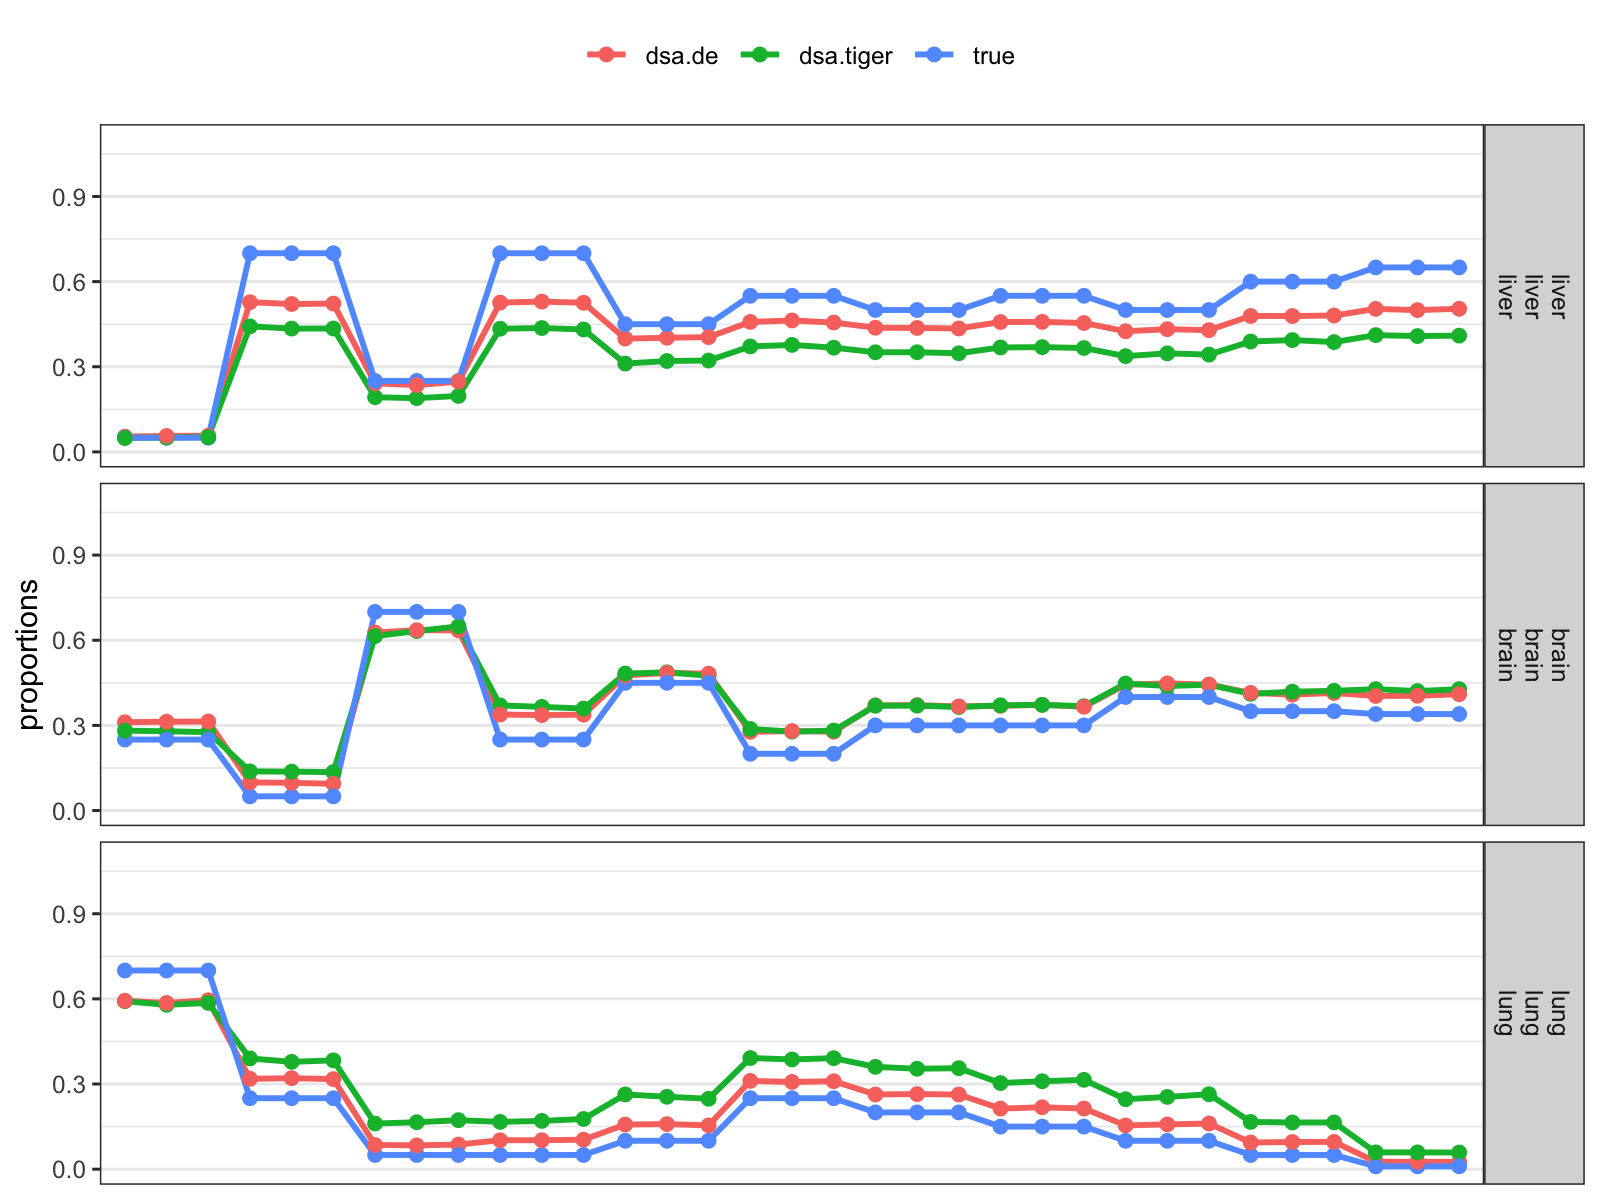

In [62]:
proportions.dsa <- list(dsa.tiger = proportions.dsa.tiger, dsa.de = proportions.dsa.de, true = proportions.true)
do.call(plotProportions, c(proportions.dsa, pnames = list(names(proportions.dsa))))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


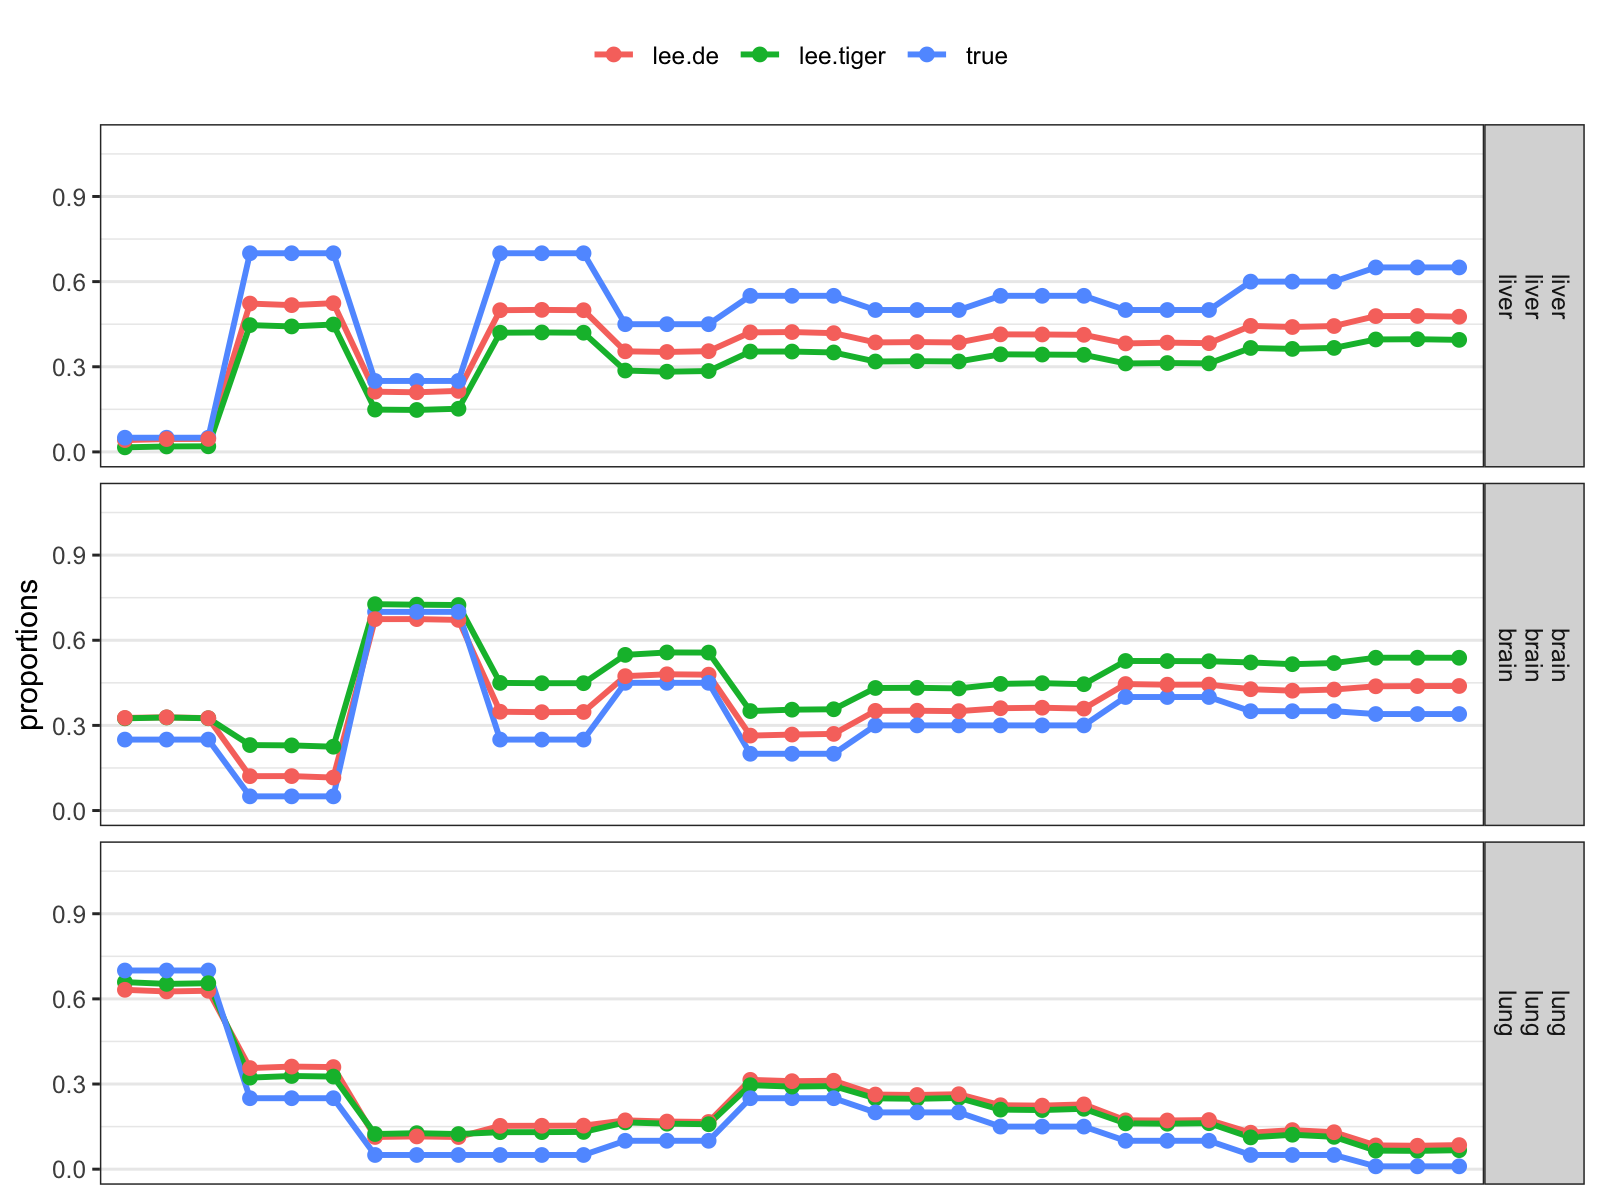

In [79]:
proportions.lee <- list(lee.tiger = proportions.lee.tiger, lee.de = proportions.lee.de, true = proportions.true)
do.call(plotProportions, c(proportions.lee, pnames = list(names(proportions.lee))))